In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch import nn
import torch.optim as optim
import time
import matplotlib.pyplot as plt
import numpy as np

In [4]:
# Set random seed for reproducibility
def set_random_seed(seed=0):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

set_random_seed(0)

# Data Augmentation and Normalization for Training
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Normalization for Testing (no data augmentation)
transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [5]:
# Load Training and Testing Data
train_dataset = datasets.ImageFolder(root='./data/train/', transform=transform_train)
test_dataset = datasets.ImageFolder(root='./data/test/', transform=transform_test)

batch_size = 64

trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of testing samples: {len(test_dataset)}")
print(f"Classes: {train_dataset.classes}")

Number of training samples: 2400
Number of testing samples: 400
Classes: ['Bedroom', 'Coast', 'Flower', 'Forest', 'Highway', 'Industrial', 'InsideCity', 'Kitchen', 'LivingRoom', 'Mountain', 'Office', 'OpenCountry', 'Store', 'Street', 'Suburb', 'TallBuilding']


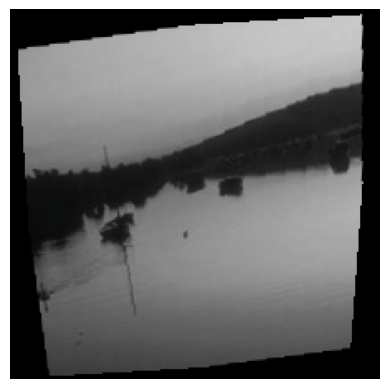

Label: Coast


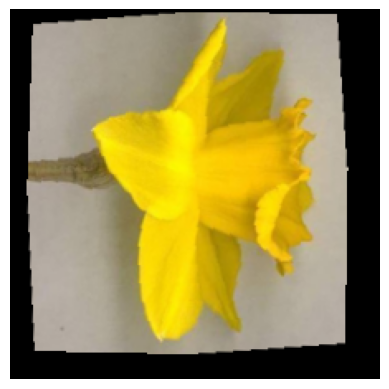

Label: Flower


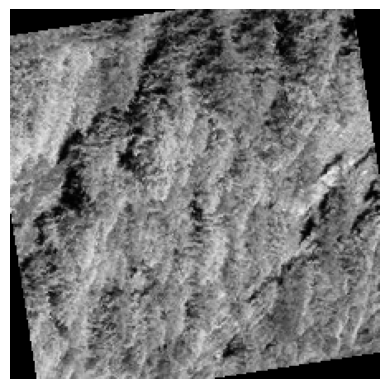

Label: Forest


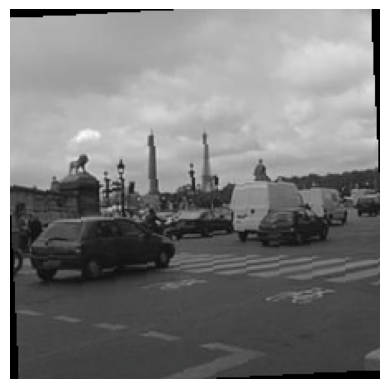

Label: Highway


In [8]:
# Function to unnormalize and show images
def imshow(img):
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    img = std * img + mean  # Unnormalize
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

# Get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Show images
for i in range(4):  
    imshow(images[i])
    print(f'Label: {train_dataset.classes[labels[i]]}')


In [6]:
# Define the Model
class EfficientNetB0(nn.Module):
    def __init__(self, num_classes):
        super(EfficientNetB0, self).__init__()
        self.efficientnet = torchvision.models.efficientnet_b0(pretrained=True)
        self.efficientnet.classifier[1] = nn.Linear(1280, num_classes)

    def forward(self, x):
        return self.efficientnet(x)

# Instantiate the Model
num_classes = len(train_dataset.classes)
net = EfficientNetB0(num_classes=num_classes)

# Set Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

net = net.to(device)

C:\Users\fhaque\Desktop\LLM\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\fhaque\Desktop\LLM\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Using device: cuda


In [9]:
# Training Function
def train_model(net, trainloader, optimizer, criterion, device, num_epochs=10, log_interval=20, testloader=None):
    start_time = time.time()
    for epoch in range(num_epochs):
        net.train()
        running_loss = 0.0
        for batch_idx, (inputs, targets) in enumerate(trainloader):
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward Pass
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            # Backward and Optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if batch_idx % log_interval == 0:
                time_elapsed = time.strftime('%H:%M:%S', time.gmtime(time.time() - start_time))
                print(f'Epoch [{epoch+1}/{num_epochs}], Step [{batch_idx}/{len(trainloader)}], '
                      f'Loss: {loss.item():.4f}, Time Elapsed: {time_elapsed}')

        if testloader is not None:
            eval_model(net, testloader, device)

# Evaluation Function
def eval_model(net, testloader, device):
    net.eval()
    correct = 0
    total = 0
    start_time = time.time()
    with torch.no_grad():
        for inputs, targets in testloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
    accuracy = 100 * correct / total
    time_elapsed = time.strftime('%H:%M:%S', time.gmtime(time.time() - start_time))
    print(f'Accuracy on test set: {accuracy:.2f}%, Time Elapsed: {time_elapsed}')

In [10]:
# Define Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

# Train the Model
num_epochs = 20
train_model(net, trainloader, optimizer, criterion, device, num_epochs=num_epochs, testloader=testloader)

Epoch [1/20], Step [0/38], Loss: 2.8354, Time Elapsed: 00:00:16
Epoch [1/20], Step [20/38], Loss: 0.7779, Time Elapsed: 00:00:19
Accuracy on test set: 80.25%, Time Elapsed: 00:00:06
Epoch [2/20], Step [0/38], Loss: 0.6821, Time Elapsed: 00:00:44
Epoch [2/20], Step [20/38], Loss: 0.5576, Time Elapsed: 00:00:47
Accuracy on test set: 84.50%, Time Elapsed: 00:00:06
Epoch [3/20], Step [0/38], Loss: 0.3807, Time Elapsed: 00:01:12
Epoch [3/20], Step [20/38], Loss: 0.2334, Time Elapsed: 00:01:15
Accuracy on test set: 90.50%, Time Elapsed: 00:00:06
Epoch [4/20], Step [0/38], Loss: 0.3607, Time Elapsed: 00:01:40
Epoch [4/20], Step [20/38], Loss: 0.1998, Time Elapsed: 00:01:43
Accuracy on test set: 89.00%, Time Elapsed: 00:00:06
Epoch [5/20], Step [0/38], Loss: 0.2000, Time Elapsed: 00:02:08
Epoch [5/20], Step [20/38], Loss: 0.1058, Time Elapsed: 00:02:12
Accuracy on test set: 87.50%, Time Elapsed: 00:00:06
Epoch [6/20], Step [0/38], Loss: 0.3285, Time Elapsed: 00:02:37
Epoch [6/20], Step [20/38]

In [ ]:
torch.save(net.state_dict(), 'EfficientNetB0_model.pth')